# 共享层和专用层分别处理

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import gym
from gym import spaces
import pandas as pd
name_count = pd.read_csv('name_count.csv')
# 转化成字典
name_count = name_count.set_index('Unnamed: 0')['count'].to_dict()



# 定义 A 和 B
A = np.random.uniform(-1, 1, size=(3, 73))  # 假设 A 的真实数据
B = np.random.uniform(-1, 1, size=(3,))    # 假设 B 的真实数据

# 解析配置变量
variables = list(name_count.keys())
participation_count = list(name_count.values())

# 找出共享变量的索引
shared_indices = [i for i, count in enumerate(participation_count) if count > 1]
shared_size = len(shared_indices)

# 自定义环境类，包含 KPI 计算逻辑
class FactoryEnv(gym.Env):
    def __init__(self, state_size, action_size, A, B):
        super(FactoryEnv, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.A = A
        self.B = B
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(state_size,), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(action_size,), dtype=np.float32)
        self.state = np.random.uniform(-1, 1, size=(state_size,))
        
    def step(self, action):
        self.state = np.clip(self.state + action, -1, 1)
        kpi1 = np.dot(self.A[0], self.state) + self.B[0]
        kpi2 = np.dot(self.A[1], self.state) + self.B[1]
        kpi3 = np.dot(self.A[2], self.state) + self.B[2]
        reward_vector = np.array([kpi1, kpi2, kpi3])  # 多目标奖励
        done = False  # 根据需要设置终止条件
        return self.state, reward_vector, done, {}
    
    def reset(self):
        self.state = np.random.uniform(-1, 1, size=(self.state_size,))
        return self.state

# 定义 Actor 和 Critic 网络
class SharedActor(nn.Module):
    def __init__(self, state_size, action_size, shared_size, weight_size):
        super(SharedActor, self).__init__()
        self.shared_fc = nn.Linear(shared_size, 128)
        self.individual_fc = nn.Linear(state_size - shared_size, 128)
        self.fc1 = nn.Linear(256 + weight_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_size)
    
    def forward(self, state, weights):
        shared_features = torch.relu(self.shared_fc(state[:, shared_indices]))
        individual_features = torch.relu(self.individual_fc(state[:, [i for i in range(state.size(1)) if i not in shared_indices]]))
        combined = torch.cat([shared_features, individual_features, weights], dim=1)
        x = torch.relu(self.fc1(combined))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

class SharedCritic(nn.Module):
    def __init__(self, state_size, action_size, shared_size, weight_size):
        super(SharedCritic, self).__init__()
        self.shared_fc = nn.Linear(shared_size, 128)
        self.individual_fc = nn.Linear(state_size - shared_size, 128)
        self.fc1 = nn.Linear(256 + action_size + weight_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, state, action, weights):
        shared_features = torch.relu(self.shared_fc(state[:, shared_indices]))
        individual_features = torch.relu(self.individual_fc(state[:, [i for i in range(state.size(1)) if i not in shared_indices]]))
        combined = torch.cat([shared_features, individual_features, action, weights], dim=1)
        x = torch.relu(self.fc1(combined))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# 定义 MORL 智能体
class MORLAgent:
    def __init__(self, state_size, action_size, shared_size, weight_size):
        self.state_size = state_size
        self.action_size = action_size
        self.weight_size = weight_size
        self.actor = SharedActor(state_size, action_size, shared_size, weight_size)
        self.critic = SharedCritic(state_size, action_size, shared_size, weight_size)
        self.target_actor = SharedActor(state_size, action_size, shared_size, weight_size)
        self.target_critic = SharedCritic(state_size, action_size, shared_size, weight_size)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.002)
        self.memory = deque(maxlen=100000)
        self.batch_size = 128
        self.gamma = 0.99
        self.tau = 0.005
        
        # 初始化目标网络参数
        self._update_target(self.target_actor, self.actor, 1.0)
        self._update_target(self.target_critic, self.critic, 1.0)

    def _update_target(self, target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    def act(self, state, weights):
        state = torch.FloatTensor(state).unsqueeze(0)
        weights = torch.FloatTensor(weights).unsqueeze(0)
        with torch.no_grad():
            action = self.actor(state, weights).squeeze(0).numpy()
        return np.clip(action + np.random.normal(0, 0.1, size=self.action_size), -1, 1)

    def remember(self, state, action, reward_vector, next_state, done, weights):
        weighted_reward = np.dot(weights, reward_vector)
        self.memory.append((state, action, weighted_reward, next_state, done, weights))

    def learn(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones, weights = zip(*batch)
        
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)
        weights = torch.FloatTensor(weights)
        
        # Critic 更新
        next_actions = self.target_actor(next_states, weights)
        next_q_values = self.target_critic(next_states, next_actions, weights)
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        q_values = self.critic(states, actions, weights)
        critic_loss = nn.MSELoss()(q_values, q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # Actor 更新
        actions_pred = self.actor(states, weights)
        actor_loss = -self.critic(states, actions_pred, weights).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # 软更新目标网络
        self._update_target(self.target_actor, self.actor, self.tau)
        self._update_target(self.target_critic, self.critic, self.tau)

# 初始化环境和智能体
env = FactoryEnv(state_size=73, action_size=73, A=A, B=B)
agent = MORLAgent(state_size=73, action_size=73, shared_size=len(shared_indices), weight_size=3)

# 开始训练
episodes = 1000
for episode in range(episodes):
    state = env.reset()
    episode_reward = 0
    done = False
    weights = np.random.dirichlet(np.ones(3), size=1)[0]
    while not done:
        action = agent.act(state, weights)
        next_state, reward_vector, done, _ = env.step(action)
        agent.remember(state, action, reward_vector, next_state, done, weights)
        agent.learn()
        state = next_state
        episode_reward += np.dot(weights, reward_vector)
    print(f"Episode {episode + 1}, Weighted Reward: {episode_reward}")


/tmp/ipykernel_4018041/2069805970.py:130: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor(states)


Episode 1, Weighted Reward: 20713.16697453889, Critic Loss: 123756036.3049519
Episode 2, Weighted Reward: 23176.44806672412, Critic Loss: 175272168.42132443
Episode 3, Weighted Reward: 21025.272721593115, Critic Loss: 141696383.42711386
Episode 4, Weighted Reward: 22358.926604759887, Critic Loss: 159120457.6265248
Episode 5, Weighted Reward: 22882.30375916794, Critic Loss: 164667638.57169452
Episode 6, Weighted Reward: 20969.91077794051, Critic Loss: 136109630.28509045
Episode 7, Weighted Reward: 21483.733287409745, Critic Loss: 141505877.5222704
Episode 8, Weighted Reward: 19473.960473615964, Critic Loss: 113974388.4570168
Episode 9, Weighted Reward: 25442.13781360719, Critic Loss: 197533119.3114353
Episode 10, Weighted Reward: 21895.54195499012, Critic Loss: 140949478.6973571
Episode 11, Weighted Reward: 18731.901951775966, Critic Loss: 100739562.32495901
Episode 12, Weighted Reward: 23439.4941085999, Critic Loss: 161052870.85831037
Episode 13, Weighted Reward: 20790.89373051717, Cri

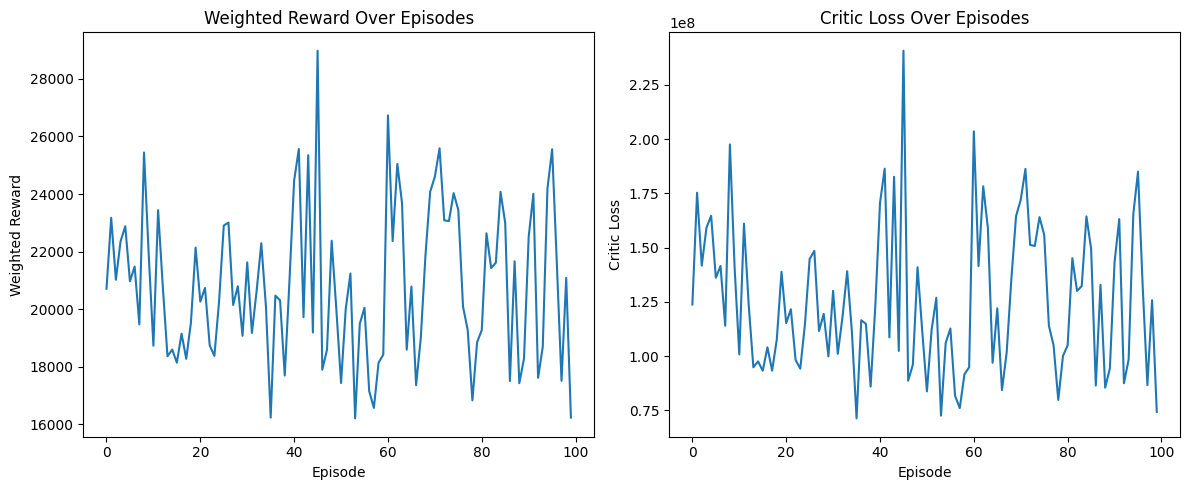

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import gym
from gym import spaces
import matplotlib.pyplot as plt

import pandas as pd
name_count = pd.read_csv('name_count.csv')
# 转化成字典
name_count_dict = name_count.set_index('Unnamed: 0')['count'].to_dict()
# 定义 A 和 B
A = np.random.uniform(-1, 1, size=(3, 73))  # 假设 A 的真实数据
B = np.random.uniform(-1, 1, size=(3,))    # 假设 B 的真实数据

# 解析配置变量
variables = list(name_count_dict.keys())
participation_count = list(name_count_dict.values())

# 找出共享变量的索引
shared_indices = [i for i, count in enumerate(participation_count) if count > 1]
shared_size = len(shared_indices)

# 自定义环境类，包含 KPI 计算逻辑
class FactoryEnv(gym.Env):
    def __init__(self, state_size, action_size, A, B):
        super(FactoryEnv, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.A = A
        self.B = B
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(state_size,), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(action_size,), dtype=np.float32)
        self.state = np.random.uniform(-1, 1, size=(state_size,))
        
    def step(self, action):
        self.state = np.clip(self.state + action, -1, 1)
        kpi1 = np.dot(self.A[0], self.state) + self.B[0]
        kpi2 = np.dot(self.A[1], self.state) + self.B[1]
        kpi3 = np.dot(self.A[2], self.state) + self.B[2]
        reward_vector = np.array([kpi1, kpi2, kpi3])  # 多目标奖励
        done = False  # 根据需要设置终止条件
        return self.state, reward_vector, done, {}
    
    def reset(self):
        self.state = np.random.uniform(-1, 1, size=(self.state_size,))
        return self.state

# 定义 Actor 和 Critic 网络
class SharedActor(nn.Module):
    def __init__(self, state_size, action_size, shared_size, weight_size):
        super(SharedActor, self).__init__()
        self.shared_fc = nn.Linear(shared_size, 128)
        self.individual_fc = nn.Linear(state_size - shared_size, 128)
        self.fc1 = nn.Linear(256 + weight_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_size)
    
    def forward(self, state, weights):
        shared_features = torch.relu(self.shared_fc(state[:, shared_indices]))
        individual_features = torch.relu(self.individual_fc(state[:, [i for i in range(state.size(1)) if i not in shared_indices]]))
        combined = torch.cat([shared_features, individual_features, weights], dim=1)
        x = torch.relu(self.fc1(combined))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

class SharedCritic(nn.Module):
    def __init__(self, state_size, action_size, shared_size, weight_size):
        super(SharedCritic, self).__init__()
        self.shared_fc = nn.Linear(shared_size, 128)
        self.individual_fc = nn.Linear(state_size - shared_size, 128)
        self.fc1 = nn.Linear(256 + action_size + weight_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, state, action, weights):
        shared_features = torch.relu(self.shared_fc(state[:, shared_indices]))
        individual_features = torch.relu(self.individual_fc(state[:, [i for i in range(state.size(1)) if i not in shared_indices]]))
        combined = torch.cat([shared_features, individual_features, action, weights], dim=1)
        x = torch.relu(self.fc1(combined))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# 定义 MORL 智能体
class MORLAgent:
    def __init__(self, state_size, action_size, shared_size, weight_size):
        self.state_size = state_size
        self.action_size = action_size
        self.weight_size = weight_size
        self.actor = SharedActor(state_size, action_size, shared_size, weight_size).to(device)
        self.critic = SharedCritic(state_size, action_size, shared_size, weight_size).to(device)
        self.target_actor = SharedActor(state_size, action_size, shared_size, weight_size).to(device)
        self.target_critic = SharedCritic(state_size, action_size, shared_size, weight_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.002)
        self.memory = deque(maxlen=100000)
        self.batch_size = 128
        self.gamma = 0.99
        self.tau = 0.005
        
        # 初始化目标网络参数
        self._update_target(self.target_actor, self.actor, 1.0)
        self._update_target(self.target_critic, self.critic, 1.0)

    def _update_target(self, target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    def act(self, state, weights):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        weights = torch.FloatTensor(weights).unsqueeze(0).to(device)
        with torch.no_grad():
            action = self.actor(state, weights).squeeze(0).cpu().numpy()
        return np.clip(action + np.random.normal(0, 0.1, size=self.action_size), -1, 1)

    def remember(self, state, action, reward_vector, next_state, done, weights):
        weighted_reward = np.dot(weights, reward_vector)
        self.memory.append((state, action, weighted_reward, next_state, done, weights))

    def learn(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones, weights = zip(*batch)
        
        # 将 numpy 数组列表合并为单个 numpy 数组来提高效率
        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.FloatTensor(np.array(actions)).to(device)
        rewards = torch.FloatTensor(np.array(rewards)).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(np.array(dones)).unsqueeze(1).to(device)
        weights = torch.FloatTensor(np.array(weights)).to(device)
        
        # Critic 更新
        next_actions = self.target_actor(next_states, weights)
        next_q_values = self.target_critic(next_states, next_actions, weights)
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        q_values = self.critic(states, actions, weights)
        critic_loss = nn.MSELoss()(q_values, q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # Actor 更新
        actions_pred = self.actor(states, weights)
        actor_loss = -self.critic(states, actions_pred, weights).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # 软更新目标网络
        self._update_target(self.target_actor, self.actor, self.tau)
        self._update_target(self.target_critic, self.critic, self.tau)

# 设备设置：使用 GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化环境和智能体
env = FactoryEnv(state_size=73, action_size=73, A=A, B=B)
agent = MORLAgent(state_size=73, action_size=73, shared_size=len(shared_indices), weight_size=3)

# 记录训练数据
reward_history = []
critic_loss_history = []

# 开始训练
episodes = 100
max_steps = 2000  # 设置最大步数来控制 episode 长度
for episode in range(episodes):
    state = env.reset()
    episode_reward = 0
    done = False
    weights = np.random.dirichlet(np.ones(3), size=1)[0]
    step_count = 0
    episode_critic_loss = 0
    while not done and step_count < max_steps:
        action = agent.act(state, weights)
        next_state, reward_vector, done, _ = env.step(action)
        agent.remember(state, action, reward_vector, next_state, done, weights)
        agent.learn()
        state = next_state
        episode_reward += np.dot(weights, reward_vector)
        step_count += 1
        
        # 记录 Critic 损失
        q_values = agent.critic(torch.FloatTensor(state).unsqueeze(0).to(device),
                                torch.FloatTensor(action).unsqueeze(0).to(device),
                                torch.FloatTensor(weights).unsqueeze(0).to(device))
        target_q_values = torch.FloatTensor([episode_reward]).unsqueeze(1).to(device)
        critic_loss = nn.MSELoss()(q_values, target_q_values)
        episode_critic_loss += critic_loss.item()
        
    reward_history.append(episode_reward)
    critic_loss_history.append(episode_critic_loss / step_count)  # 平均损失
    print(f"Episode {episode + 1}, Weighted Reward: {episode_reward}, Critic Loss: {episode_critic_loss / step_count}")

# 绘制训练过程中的加权奖励和 Critic 损失图像
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(reward_history)
plt.title('Weighted Reward Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Weighted Reward')

plt.subplot(1, 2, 2)
plt.plot(critic_loss_history)
plt.title('Critic Loss Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Critic Loss')

plt.tight_layout()
plt.show()


# 多头注意力机制

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random
import gym
from gym import spaces

# 自定义多头注意力模块
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, x):
        x = x.unsqueeze(0)  # 增加批次维度
        attn_output, _ = self.attention(x, x, x)  # 自注意力
        return attn_output.squeeze(0)  # 移除批次维度

# Actor 网络，带多头注意力机制
class AttentionActor(nn.Module):
    def __init__(self, state_size, action_size, shared_size, weight_size, embed_dim=128, num_heads=4):
        super(AttentionActor, self).__init__()
        self.shared_attention = MultiHeadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.individual_fc = nn.Linear(state_size - shared_size, embed_dim)
        self.fc1 = nn.Linear(2 * embed_dim + weight_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_size)
    
    def forward(self, state, weights):
        shared_features = state[:, shared_indices]
        shared_features = self.shared_attention(shared_features)
        individual_features = torch.relu(self.individual_fc(state[:, [i for i in range(state.size(1)) if i not in shared_indices]]))
        combined = torch.cat([shared_features, individual_features, weights], dim=1)
        x = torch.relu(self.fc1(combined))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

# Critic 网络，带多头注意力机制
class AttentionCritic(nn.Module):
    def __init__(self, state_size, action_size, shared_size, weight_size, embed_dim=128, num_heads=4):
        super(AttentionCritic, self).__init__()
        self.shared_attention = MultiHeadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.individual_fc = nn.Linear(state_size - shared_size, embed_dim)
        self.fc1 = nn.Linear(2 * embed_dim + action_size + weight_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, state, action, weights):
        shared_features = state[:, shared_indices]
        shared_features = self.shared_attention(shared_features)
        individual_features = torch.relu(self.individual_fc(state[:, [i for i in range(state.size(1)) if i not in shared_indices]]))
        combined = torch.cat([shared_features, individual_features, action, weights], dim=1)
        x = torch.relu(self.fc1(combined))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# 定义 MORL 智能体
class MORLAgent:
    def __init__(self, state_size, action_size, shared_size, weight_size):
        self.state_size = state_size
        self.action_size = action_size
        self.weight_size = weight_size
        self.actor = AttentionActor(state_size, action_size, shared_size, weight_size)
        self.critic = AttentionCritic(state_size, action_size, shared_size, weight_size)
        self.target_actor = AttentionActor(state_size, action_size, shared_size, weight_size)
        self.target_critic = AttentionCritic(state_size, action_size, shared_size, weight_size)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.002)
        self.memory = deque(maxlen=100000)
        self.batch_size = 128
        self.gamma = 0.99
        self.tau = 0.005
        
        # 初始化目标网络参数
        self._update_target(self.target_actor, self.actor, 1.0)
        self._update_target(self.target_critic, self.critic, 1.0)

    def _update_target(self, target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    def act(self, state, weights):
        state = torch.FloatTensor(state).unsqueeze(0)
        weights = torch.FloatTensor(weights).unsqueeze(0)
        with torch.no_grad():
            action = self.actor(state, weights).squeeze(0).numpy()
        return np.clip(action + np.random.normal(0, 0.1, size=self.action_size), -1, 1)

    def remember(self, state, action, reward_vector, next_state, done, weights):
        weighted_reward = np.dot(weights, reward_vector)
        self.memory.append((state, action, weighted_reward, next_state, done, weights))

    def learn(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones, weights = zip(*batch)
        
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)
        weights = torch.FloatTensor(weights)
        
        # Critic 更新
        next_actions = self.target_actor(next_states, weights)
        next_q_values = self.target_critic(next_states, next_actions, weights)
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        q_values = self.critic(states, actions, weights)
        critic_loss = nn.MSELoss()(q_values, q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # Actor 更新
        actions_pred = self.actor(states, weights)
        actor_loss = -self.critic(states, actions_pred, weights).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # 软更新目标网络
        self._update_target(self.target_actor, self.actor, self.tau)
        self._update_target(self.target_critic, self.critic, self.tau)

# 初始化环境和智能体
env = FactoryEnv(state_size=73, action_size=73, A=A, B=B)
agent = MORLAgent(state_size=73, action_size=73, shared_size=len(shared_indices), weight_size=3)

# 开始训练
episodes = 1000
for episode in range(episodes):
    state = env.reset()
    episode_reward = 0
    done = False
    weights = np.random.dirichlet(np.ones(3), size=1)[0]
    while not done:
        action = agent.act(state, weights)
        next_state, reward_vector, done, _ = env.step(action)
        agent.remember(state, action, reward_vector, next_state, done, weights)
        agent.learn()
        state = next_state
        episode_reward += np.dot(weights, reward_vector)
    print(f"Episode {episode + 1}, Weighted Reward: {episode_reward}")


# 市场条件变动下的 多头注意力机制

Episode 1: 100%|██████████| 50000/50000 [01:22<00:00, 604.92it/s]


Episode 1, Weighted Reward: 11356042.964836696, Critic Loss: 6145.3932397092585


Episode 2: 100%|██████████| 50000/50000 [01:22<00:00, 604.44it/s]


Episode 2, Weighted Reward: 16150803.511237329, Critic Loss: 30492.922296547968


Episode 3: 100%|██████████| 50000/50000 [01:22<00:00, 606.28it/s]


Episode 3, Weighted Reward: 16336360.56596815, Critic Loss: 46875.39800197141


Episode 4: 100%|██████████| 50000/50000 [01:21<00:00, 611.72it/s]


Episode 4, Weighted Reward: 19775767.813806232, Critic Loss: 61737.67890581746


Episode 5: 100%|██████████| 50000/50000 [01:21<00:00, 610.99it/s]


Episode 5, Weighted Reward: 19019803.974329814, Critic Loss: 77288.06215341538


Episode 6: 100%|██████████| 50000/50000 [01:22<00:00, 603.39it/s]


Episode 6, Weighted Reward: 19267632.895152934, Critic Loss: 87179.51616480047


Episode 7: 100%|██████████| 50000/50000 [01:24<00:00, 590.11it/s]


Episode 7, Weighted Reward: 19245676.482617438, Critic Loss: 98669.388494799


Episode 8: 100%|██████████| 50000/50000 [01:26<00:00, 578.37it/s]


Episode 8, Weighted Reward: 19288867.98161195, Critic Loss: 106758.8628624856


Episode 9: 100%|██████████| 50000/50000 [01:24<00:00, 592.61it/s]


Episode 9, Weighted Reward: 19475961.527954925, Critic Loss: 112011.57350283171


Episode 10: 100%|██████████| 50000/50000 [01:22<00:00, 604.26it/s]


Episode 10, Weighted Reward: 19907614.496258974, Critic Loss: 116820.30842137456


Episode 11: 100%|██████████| 50000/50000 [01:23<00:00, 600.72it/s]


Episode 11, Weighted Reward: 19566325.59056521, Critic Loss: 131718.7108217318


Episode 12: 100%|██████████| 50000/50000 [01:23<00:00, 601.08it/s]


Episode 12, Weighted Reward: 19422544.742733054, Critic Loss: 142020.33938456923


Episode 13: 100%|██████████| 50000/50000 [01:23<00:00, 600.34it/s]


Episode 13, Weighted Reward: 19558318.520791277, Critic Loss: 150145.753543454


Episode 14: 100%|██████████| 50000/50000 [01:23<00:00, 596.42it/s]


Episode 14, Weighted Reward: 19348684.784294084, Critic Loss: 150785.56338893066


Episode 15: 100%|██████████| 50000/50000 [01:24<00:00, 595.22it/s]


Episode 15, Weighted Reward: 19698662.745886937, Critic Loss: 148461.247376503


Episode 16: 100%|██████████| 50000/50000 [01:23<00:00, 596.51it/s]


Episode 16, Weighted Reward: 19408018.78413491, Critic Loss: 144890.61121077515


Episode 17: 100%|██████████| 50000/50000 [01:23<00:00, 600.51it/s]


Episode 17, Weighted Reward: 19178158.717569824, Critic Loss: 135794.81566216217


Episode 18: 100%|██████████| 50000/50000 [01:24<00:00, 594.29it/s]


Episode 18, Weighted Reward: 19549104.37056416, Critic Loss: 128168.75914436142


Episode 19: 100%|██████████| 50000/50000 [01:24<00:00, 595.12it/s]


Episode 19, Weighted Reward: 19706737.442347243, Critic Loss: 119602.88049140258


Episode 20: 100%|██████████| 50000/50000 [01:23<00:00, 595.70it/s]


Episode 20, Weighted Reward: 19326519.009047538, Critic Loss: 110762.82186936097


Episode 21: 100%|██████████| 50000/50000 [01:23<00:00, 599.89it/s]


Episode 21, Weighted Reward: 19041203.48703572, Critic Loss: 103196.32106361451


Episode 22: 100%|██████████| 50000/50000 [01:22<00:00, 605.20it/s]


Episode 22, Weighted Reward: 19796965.723932378, Critic Loss: 94436.98704103928


Episode 23: 100%|██████████| 50000/50000 [01:22<00:00, 606.86it/s]


Episode 23, Weighted Reward: 19774472.34309507, Critic Loss: 89015.01738354111


Episode 24: 100%|██████████| 50000/50000 [01:22<00:00, 605.79it/s]


Episode 24, Weighted Reward: 19279025.77068906, Critic Loss: 85232.74180182816


Episode 25: 100%|██████████| 50000/50000 [01:22<00:00, 603.27it/s]


Episode 25, Weighted Reward: 18809992.98416127, Critic Loss: 78648.92161674668


Episode 26: 100%|██████████| 50000/50000 [01:23<00:00, 602.09it/s]


Episode 26, Weighted Reward: 19489962.75260225, Critic Loss: 76273.22150780335


Episode 27: 100%|██████████| 50000/50000 [01:22<00:00, 606.47it/s]


Episode 27, Weighted Reward: 19647927.60137905, Critic Loss: 75292.06658105335


Episode 28: 100%|██████████| 50000/50000 [01:22<00:00, 608.32it/s]


Episode 28, Weighted Reward: 20029214.057217862, Critic Loss: 77264.32933998562


Episode 29: 100%|██████████| 50000/50000 [01:22<00:00, 604.86it/s]


Episode 29, Weighted Reward: 19099380.12472211, Critic Loss: 77983.31102944232


Episode 30: 100%|██████████| 50000/50000 [01:25<00:00, 585.26it/s]


Episode 30, Weighted Reward: 19922878.82744254, Critic Loss: 79038.66389018849


Episode 31: 100%|██████████| 50000/50000 [01:24<00:00, 589.57it/s]


Episode 31, Weighted Reward: 19311072.823019344, Critic Loss: 79453.38040417897


Episode 32: 100%|██████████| 50000/50000 [01:25<00:00, 584.87it/s]


Episode 32, Weighted Reward: 19688718.36952812, Critic Loss: 82926.26699522251


Episode 33: 100%|██████████| 50000/50000 [01:25<00:00, 584.88it/s]


Episode 33, Weighted Reward: 19305069.97226688, Critic Loss: 77748.79441259151


Episode 34: 100%|██████████| 50000/50000 [01:25<00:00, 585.99it/s]


Episode 34, Weighted Reward: 19768737.625193402, Critic Loss: 76953.27338026516


Episode 35: 100%|██████████| 50000/50000 [01:25<00:00, 587.54it/s]


Episode 35, Weighted Reward: 19460333.480132602, Critic Loss: 80127.64288172466


Episode 36: 100%|██████████| 50000/50000 [01:22<00:00, 604.68it/s]


Episode 36, Weighted Reward: 19790218.24134912, Critic Loss: 80508.75891591201


Episode 37: 100%|██████████| 50000/50000 [01:22<00:00, 603.88it/s]


Episode 37, Weighted Reward: 19293643.94184086, Critic Loss: 79652.59148929718


Episode 38: 100%|██████████| 50000/50000 [01:24<00:00, 592.00it/s]


Episode 38, Weighted Reward: 19470344.487760473, Critic Loss: 75912.49305398414


Episode 39: 100%|██████████| 50000/50000 [01:23<00:00, 596.37it/s]


Episode 39, Weighted Reward: 19154272.51153625, Critic Loss: 73131.32435426071


Episode 40: 100%|██████████| 50000/50000 [01:23<00:00, 600.51it/s]


Episode 40, Weighted Reward: 20053607.818483446, Critic Loss: 69224.36922547856


Episode 41: 100%|██████████| 50000/50000 [01:22<00:00, 605.91it/s]


Episode 41, Weighted Reward: 18906277.108485624, Critic Loss: 66061.99550233241


Episode 42: 100%|██████████| 50000/50000 [01:22<00:00, 609.65it/s]


Episode 42, Weighted Reward: 19667847.836019006, Critic Loss: 61244.37689455341


Episode 43: 100%|██████████| 50000/50000 [01:22<00:00, 608.62it/s]


Episode 43, Weighted Reward: 19439187.562254958, Critic Loss: 61815.67245175785


Episode 44: 100%|██████████| 50000/50000 [01:21<00:00, 610.05it/s]


Episode 44, Weighted Reward: 19302031.976572614, Critic Loss: 61319.853597149886


Episode 45: 100%|██████████| 50000/50000 [01:22<00:00, 607.05it/s]


Episode 45, Weighted Reward: 19580527.13462632, Critic Loss: 57793.263242822955


Episode 46: 100%|██████████| 50000/50000 [01:22<00:00, 603.44it/s]


Episode 46, Weighted Reward: 19514721.975285817, Critic Loss: 54694.11361412365


Episode 47: 100%|██████████| 50000/50000 [01:22<00:00, 603.20it/s]


Episode 47, Weighted Reward: 19900176.44905233, Critic Loss: 54014.43425885963


Episode 48: 100%|██████████| 50000/50000 [01:23<00:00, 596.82it/s]


Episode 48, Weighted Reward: 19496855.138300274, Critic Loss: 52764.914070529616


Episode 49: 100%|██████████| 50000/50000 [01:21<00:00, 612.51it/s]


Episode 49, Weighted Reward: 19197921.388287265, Critic Loss: 55518.98859721236


Episode 50: 100%|██████████| 50000/50000 [01:21<00:00, 612.32it/s]


Episode 50, Weighted Reward: 19243850.96332278, Critic Loss: 57765.51967011506


Episode 51: 100%|██████████| 50000/50000 [01:22<00:00, 602.54it/s]


Episode 51, Weighted Reward: 19131787.2198762, Critic Loss: 57857.97355265302


Episode 52: 100%|██████████| 50000/50000 [01:22<00:00, 604.70it/s]


Episode 52, Weighted Reward: 20118835.840555806, Critic Loss: 56402.51309146981


Episode 53: 100%|██████████| 50000/50000 [01:22<00:00, 604.72it/s]


Episode 53, Weighted Reward: 19357530.667708535, Critic Loss: 55214.10011514641


Episode 54: 100%|██████████| 50000/50000 [01:26<00:00, 579.38it/s]


Episode 54, Weighted Reward: 19530625.066789888, Critic Loss: 53537.81284676772


Episode 55: 100%|██████████| 50000/50000 [01:25<00:00, 581.96it/s]


Episode 55, Weighted Reward: 19255555.32361551, Critic Loss: 54409.50636615394


Episode 56: 100%|██████████| 50000/50000 [01:26<00:00, 579.19it/s]


Episode 56, Weighted Reward: 19420105.419956826, Critic Loss: 54259.764123304194


Episode 57: 100%|██████████| 50000/50000 [01:27<00:00, 571.55it/s]


Episode 57, Weighted Reward: 19626013.806855418, Critic Loss: 54327.32338354364


Episode 58: 100%|██████████| 50000/50000 [01:22<00:00, 602.99it/s]


Episode 58, Weighted Reward: 18811719.5709277, Critic Loss: 52750.542619349464


Episode 59: 100%|██████████| 50000/50000 [01:23<00:00, 599.57it/s]


Episode 59, Weighted Reward: 18903128.34910592, Critic Loss: 56806.79651861679


Episode 60: 100%|██████████| 50000/50000 [01:24<00:00, 589.59it/s]


Episode 60, Weighted Reward: 19205049.547890507, Critic Loss: 55404.99477513235


Episode 61: 100%|██████████| 50000/50000 [01:23<00:00, 601.29it/s]


Episode 61, Weighted Reward: 19190479.539216448, Critic Loss: 56771.25536871042


Episode 62: 100%|██████████| 50000/50000 [01:23<00:00, 598.25it/s]


Episode 62, Weighted Reward: 19684633.20459409, Critic Loss: 57667.86121027731


Episode 63: 100%|██████████| 50000/50000 [01:24<00:00, 590.61it/s]


Episode 63, Weighted Reward: 19590814.37498598, Critic Loss: 58382.99906708004


Episode 64: 100%|██████████| 50000/50000 [01:24<00:00, 590.98it/s]


Episode 64, Weighted Reward: 19754377.857287474, Critic Loss: 58741.43018384962


Episode 65: 100%|██████████| 50000/50000 [01:26<00:00, 579.66it/s]


Episode 65, Weighted Reward: 20093947.929332554, Critic Loss: 57631.742622732105


Episode 66: 100%|██████████| 50000/50000 [01:26<00:00, 576.66it/s]


Episode 66, Weighted Reward: 19255271.039697967, Critic Loss: 57585.59848061455


Episode 67: 100%|██████████| 50000/50000 [01:26<00:00, 576.78it/s]


Episode 67, Weighted Reward: 19126074.54978832, Critic Loss: 56056.710789382705


Episode 68: 100%|██████████| 50000/50000 [01:24<00:00, 590.33it/s]


Episode 68, Weighted Reward: 19570687.424997065, Critic Loss: 56701.46202379331


Episode 69: 100%|██████████| 50000/50000 [01:23<00:00, 598.04it/s]


Episode 69, Weighted Reward: 19505202.685203306, Critic Loss: 50006.391324675504


Episode 70: 100%|██████████| 50000/50000 [01:22<00:00, 608.38it/s]


Episode 70, Weighted Reward: 19573216.84818563, Critic Loss: 51179.731789738944


Episode 71: 100%|██████████| 50000/50000 [01:22<00:00, 606.64it/s]


Episode 71, Weighted Reward: 20016183.918023422, Critic Loss: 51755.270891550615


Episode 72: 100%|██████████| 50000/50000 [01:22<00:00, 607.29it/s]


Episode 72, Weighted Reward: 19417479.76751922, Critic Loss: 52261.54751637167


Episode 73: 100%|██████████| 50000/50000 [01:22<00:00, 603.09it/s]


Episode 73, Weighted Reward: 19806979.536593713, Critic Loss: 52057.2400010248


Episode 74: 100%|██████████| 50000/50000 [01:22<00:00, 607.69it/s]


Episode 74, Weighted Reward: 19720998.323034495, Critic Loss: 52493.44093275608


Episode 75: 100%|██████████| 50000/50000 [01:22<00:00, 607.07it/s]


Episode 75, Weighted Reward: 19345491.571614098, Critic Loss: 53243.95062184902


Episode 76: 100%|██████████| 50000/50000 [01:22<00:00, 608.36it/s]


Episode 76, Weighted Reward: 20125447.180226725, Critic Loss: 55237.43928905354


Episode 77: 100%|██████████| 50000/50000 [01:22<00:00, 606.10it/s]


Episode 77, Weighted Reward: 19670277.52096913, Critic Loss: 59652.78264036175


Episode 78: 100%|██████████| 50000/50000 [01:22<00:00, 608.02it/s]


Episode 78, Weighted Reward: 20070959.41316206, Critic Loss: 61076.40084564741


Episode 79: 100%|██████████| 50000/50000 [01:22<00:00, 605.90it/s]


Episode 79, Weighted Reward: 19285278.059670024, Critic Loss: 63011.34541176931


Episode 80: 100%|██████████| 50000/50000 [01:23<00:00, 601.03it/s]


Episode 80, Weighted Reward: 19581916.191551838, Critic Loss: 62676.53274598978


Episode 81: 100%|██████████| 50000/50000 [01:23<00:00, 599.55it/s]


Episode 81, Weighted Reward: 19496755.368757654, Critic Loss: 61402.26284452764


Episode 82: 100%|██████████| 50000/50000 [01:24<00:00, 593.43it/s]


Episode 82, Weighted Reward: 19861977.563796256, Critic Loss: 62461.415393044605


Episode 83: 100%|██████████| 50000/50000 [01:22<00:00, 605.49it/s]


Episode 83, Weighted Reward: 19659990.808963455, Critic Loss: 61754.33759763575


Episode 84: 100%|██████████| 50000/50000 [01:24<00:00, 593.69it/s]


Episode 84, Weighted Reward: 19844015.584881272, Critic Loss: 62495.48092821815


Episode 85: 100%|██████████| 50000/50000 [01:25<00:00, 587.80it/s]


Episode 85, Weighted Reward: 19760990.39575914, Critic Loss: 62822.36131070129


Episode 86: 100%|██████████| 50000/50000 [01:23<00:00, 600.52it/s]


Episode 86, Weighted Reward: 19424763.86939362, Critic Loss: 60917.74008936159


Episode 87: 100%|██████████| 50000/50000 [01:22<00:00, 605.83it/s]


Episode 87, Weighted Reward: 20301925.698346455, Critic Loss: 61134.67924491045


Episode 88: 100%|██████████| 50000/50000 [01:24<00:00, 594.90it/s]


Episode 88, Weighted Reward: 19320300.326465886, Critic Loss: 60385.324057392885


Episode 89: 100%|██████████| 50000/50000 [01:23<00:00, 597.12it/s]


Episode 89, Weighted Reward: 19337899.374156997, Critic Loss: 61019.43852388546


Episode 90: 100%|██████████| 50000/50000 [01:23<00:00, 600.69it/s]


Episode 90, Weighted Reward: 19417126.03482928, Critic Loss: 59572.888982314355


Episode 91: 100%|██████████| 50000/50000 [01:22<00:00, 605.30it/s]


Episode 91, Weighted Reward: 18864945.57429265, Critic Loss: 60204.95102058


Episode 92: 100%|██████████| 50000/50000 [01:23<00:00, 598.34it/s]


Episode 92, Weighted Reward: 19721155.44344979, Critic Loss: 57454.238195727885


Episode 93: 100%|██████████| 50000/50000 [01:22<00:00, 604.82it/s]


Episode 93, Weighted Reward: 19396437.745953526, Critic Loss: 60390.06067121281


Episode 94: 100%|██████████| 50000/50000 [01:24<00:00, 590.82it/s]


Episode 94, Weighted Reward: 19089458.439174525, Critic Loss: 59964.43500659052


Episode 95: 100%|██████████| 50000/50000 [01:22<00:00, 605.09it/s]


Episode 95, Weighted Reward: 19043912.090019304, Critic Loss: 58062.32197767296


Episode 96: 100%|██████████| 50000/50000 [01:23<00:00, 600.51it/s]


Episode 96, Weighted Reward: 19606421.27013692, Critic Loss: 58505.14657907572


Episode 97: 100%|██████████| 50000/50000 [01:22<00:00, 606.46it/s]


Episode 97, Weighted Reward: 18973176.87809263, Critic Loss: 55109.56326245138


Episode 98: 100%|██████████| 50000/50000 [01:22<00:00, 603.84it/s]


Episode 98, Weighted Reward: 19956253.652651954, Critic Loss: 55034.523758534146


Episode 99: 100%|██████████| 50000/50000 [01:23<00:00, 599.56it/s]


Episode 99, Weighted Reward: 19391588.37437393, Critic Loss: 52905.53316424475


Episode 100: 100%|██████████| 50000/50000 [01:23<00:00, 600.68it/s]


Episode 100, Weighted Reward: 18871166.95959193, Critic Loss: 52785.384509617536


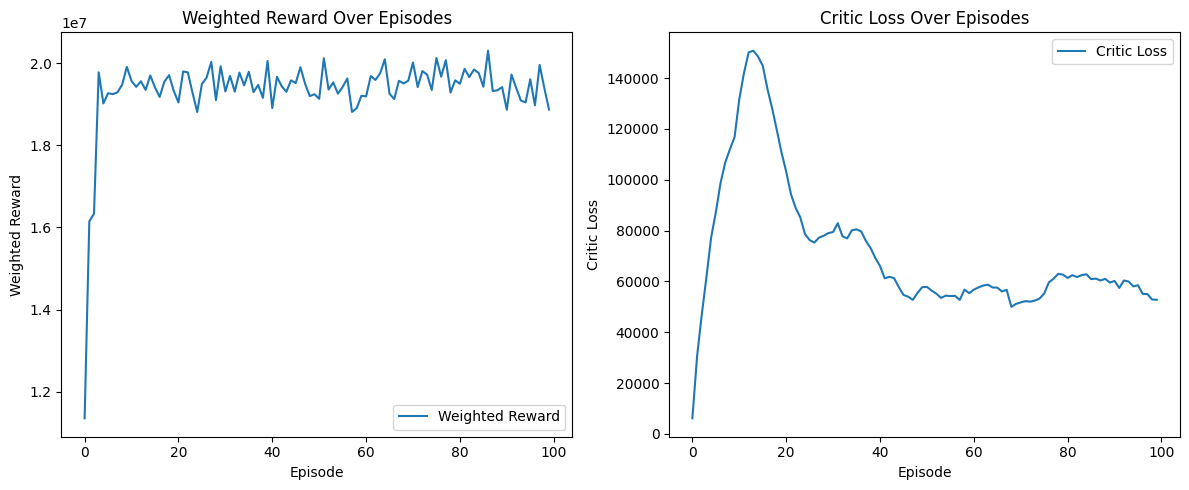

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random
import gym
from gym import spaces
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# 读取 name_count.csv 转化为字典
name_count = pd.read_csv('name_count.csv')
name_count_dict = name_count.set_index('Unnamed: 0')['count'].to_dict()

variables = list(name_count_dict.keys())
participation_count = list(name_count_dict.values())

# 找出共享变量的索引（即参与次数超过一次的变量）
shared_indices = [i for i, count in enumerate(participation_count) if count > 1]
shared_size = len(shared_indices)

# 定义 A 和 B 的初始值
A_mean = 30  # 假设均值
A_std = 1   # 假设标准差
B = np.random.uniform(-1, 1, size=(3,))  # B 的固定值

# 自定义环境类，包含 KPI 计算逻辑
class FactoryEnv(gym.Env):
    def __init__(self, state_size, action_size, B, max_steps=50000):
        super(FactoryEnv, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.B = B
        self.max_steps = max_steps
        self.current_step = 0
        self.A = np.random.normal(A_mean, A_std, size=(3, state_size))  # 初始的 A
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(state_size,), dtype=np.float32)
        self.action_space = spaces.Box(low=-1, high=1, shape=(action_size,), dtype=np.float32)
        self.state = np.random.uniform(-1, 1, size=(state_size,))
        
    def step(self, action):
        self.current_step += 1
        self.state = np.clip(self.state + action, -1, 1)
        kpi1 = np.dot(self.A[0], self.state) + self.B[0]
        kpi2 = np.dot(self.A[1], self.state) + self.B[1]
        kpi3 = np.dot(self.A[2], self.state) + self.B[2]
        reward_vector = np.array([kpi1, kpi2, kpi3])  # 多目标奖励
        done = self.current_step >= self.max_steps  # 根据步数终止
        return self.state, reward_vector, done, {}
    
    def reset(self):
        self.state = np.random.uniform(-1, 1, size=(self.state_size,))
        self.current_step = 0
        # 每次重置时重新生成 A 的值
        self.A = np.random.normal(A_mean, A_std, size=(3, self.state_size))
        return self.state

# 自定义多头注意力模块
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)  # 自注意力
        return attn_output

# Actor 网络，带多头注意力机制
class AttentionActor(nn.Module):
    def __init__(self, state_size, action_size, shared_size, weight_size, embed_dim=63, num_heads=3):
        super(AttentionActor, self).__init__()
        self.shared_attention = MultiHeadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.shared_fc = nn.Linear(shared_size, embed_dim)  # 使用 shared_size
        self.individual_fc = nn.Linear(state_size - shared_size, embed_dim)
        self.fc1 = nn.Linear(2 * embed_dim + weight_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_size)
    
    def forward(self, state, weights):
        shared_features = torch.relu(self.shared_fc(state[:, shared_indices]))
        shared_features = shared_features.unsqueeze(1)  # 调整为 (batch_size, seq_length, embed_dim) 格式
        shared_features = self.shared_attention(shared_features).squeeze(1)
        individual_features = torch.relu(self.individual_fc(state[:, [i for i in range(state.size(1)) if i not in shared_indices]]))
        combined = torch.cat([shared_features, individual_features, weights], dim=1)
        x = torch.relu(self.fc1(combined))
        x = torch.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

# 调整 Critic 网络结构（增加复杂度）
class AttentionCritic(nn.Module):
    def __init__(self, state_size, action_size, shared_size, weight_size, embed_dim=63, num_heads=3):
        super(AttentionCritic, self).__init__()
        self.shared_attention = MultiHeadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.shared_fc = nn.Linear(shared_size, embed_dim)  # 使用 shared_size
        self.individual_fc = nn.Linear(state_size - shared_size, embed_dim)
        self.fc1 = nn.Linear(2 * embed_dim + action_size + weight_size, 256)  # 增加层的宽度
        self.fc2 = nn.Linear(256, 128)  # 增加一层
        self.fc3 = nn.Linear(128, 64)   # 增加一层
        self.fc4 = nn.Linear(64, 1)     # 输出层
    
    def forward(self, state, action, weights):
        shared_features = torch.relu(self.shared_fc(state[:, shared_indices]))
        shared_features = shared_features.unsqueeze(1)  # 调整为 (batch_size, seq_length, embed_dim) 格式
        shared_features = self.shared_attention(shared_features).squeeze(1)
        individual_features = torch.relu(self.individual_fc(state[:, [i for i in range(state.size(1)) if i not in shared_indices]]))
        combined = torch.cat([shared_features, individual_features, action, weights], dim=1)
        x = torch.relu(self.fc1(combined))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# 定义 MORL 智能体
class MORLAgent:
    def __init__(self, state_size, action_size, shared_size, weight_size, device):
        self.state_size = state_size
        self.action_size = action_size
        self.weight_size = weight_size
        self.device = device
        self.actor = AttentionActor(state_size, action_size, shared_size, weight_size).to(device)
        self.critic = AttentionCritic(state_size, action_size, shared_size, weight_size).to(device)
        self.target_actor = AttentionActor(state_size, action_size, shared_size, weight_size).to(device)
        self.target_critic = AttentionCritic(state_size, action_size, shared_size, weight_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.001)  # 调低学习率 for Critic Loss

        self.memory = deque(maxlen=100000)
        self.batch_size = 128
        self.gamma = 0.99
        self.tau = 0.01
        self.learn_every = 10  # 每隔多少步进行一次学习
        self.critic_loss_history = []  # 存储 Critic 损失历史
        
        # 初始化目标网络参数
        self._update_target(self.target_actor, self.actor, 1.0)
        self._update_target(self.target_critic, self.critic, 1.0)

    def _update_target(self, target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    def act(self, state, weights):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        weights = torch.FloatTensor(weights).unsqueeze(0).to(self.device)
        with torch.no_grad():
            action = self.actor(state, weights).squeeze(0).cpu().numpy()
        return np.clip(action + np.random.normal(0, 0.1, size=self.action_size), -1, 1)

    def remember(self, state, action, reward_vector, next_state, done, weights):
        weighted_reward = np.dot(weights, reward_vector)
        self.memory.append((state, action, weighted_reward, next_state, done, weights))

    def learn(self, step_count):
        if len(self.memory) < self.batch_size or step_count % self.learn_every != 0:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones, weights = zip(*batch)
        
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.FloatTensor(np.array(actions)).to(self.device)
        rewards = torch.FloatTensor(np.array(rewards)).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(np.array(dones)).unsqueeze(1).to(self.device)
        weights = torch.FloatTensor(np.array(weights)).to(self.device)
        
        # Critic 更新
        next_actions = self.target_actor(next_states, weights)
        next_q_values = self.target_critic(next_states, next_actions, weights)
        q_targets = rewards + self.gamma * next_q_values * (1 - dones)
        q_values = self.critic(states, actions, weights)
        critic_loss = nn.MSELoss()(q_values, q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=1.0)  # 在反向传播后进行梯度裁剪 for critic Loss Optimization
        self.critic_optimizer.step()

        # 保存 Critic 损失
        self.critic_loss_history.append(critic_loss.item())
        
        # Actor 更新
        actions_pred = self.actor(states, weights)
        actor_loss = -self.critic(states, actions_pred, weights).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # 软更新目标网络
        self._update_target(self.target_actor, self.actor, self.tau)
        self._update_target(self.target_critic, self.critic, self.tau)

# 设备设置：使用 GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化环境和智能体
env = FactoryEnv(state_size=73, action_size=73, B=B, max_steps=50000)
agent = MORLAgent(state_size=73, action_size=73, shared_size=len(shared_indices), weight_size=3, device=device)

# 记录训练数据
reward_history = []
critic_loss_history = []

# 开始训练
episodes = 100
for episode in range(episodes):
    state = env.reset()
    episode_reward = 0
    done = False
    weights = np.random.dirichlet(np.ones(3), size=1)[0]
    step_count = 0

    # 使用 tqdm 显示训练进度
    with tqdm(total=env.max_steps, desc=f"Episode {episode + 1}") as pbar:
        while not done:
            action = agent.act(state, weights)
            next_state, reward_vector, done, _ = env.step(action)
            agent.remember(state, action, reward_vector, next_state, done, weights)
            agent.learn(step_count)
            state = next_state
            episode_reward += np.dot(weights, reward_vector)
            step_count += 1
            pbar.update(1)  # 更新进度条

    reward_history.append(episode_reward)
    critic_loss_history.append(np.mean(agent.critic_loss_history[-step_count:]))  # 记录每个 episode 的平均 Critic 损失
    print(f"Episode {episode + 1}, Weighted Reward: {episode_reward}, Critic Loss: {critic_loss_history[-1]}")

# 绘制训练过程中的加权奖励和 Critic 损失图像
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(reward_history, label='Weighted Reward')
plt.title('Weighted Reward Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Weighted Reward')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(critic_loss_history, label='Critic Loss')
plt.title('Critic Loss Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Critic Loss')
plt.legend()

plt.tight_layout()
plt.show()
